In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.signal import periodogram
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.signal import find_peaks

In [32]:
gold_dataset_addr = "./data/Gold Price.csv"
gold_dataset = pd.read_csv(gold_dataset_addr)
gold_dataset.head(10)

,Date,Price,Open,High,Low,Volume,Chg%
0,2025-01-06,77149,77309,77542,76545,27160,0.44
1,2025-01-03,76813,77246,78600,76613,60,-0.05
2,2025-01-02,76849,76849,76849,76849,0,0.83
3,2025-01-01,76214,76232,76302,76053,60,-0.02
4,2024-12-31,76232,75680,76970,75572,1920,0.95
5,2024-12-30,75517,75443,76450,75336,10260,-0.35
6,2024-12-27,75783,76160,76445,75661,15260,-0.43
7,2024-12-26,76114,75868,76200,75760,9730,0.73
8,2024-12-24,75562,75625,75688,75424,10820,0.07
9,2024-12-23,75506,75680,75964,75352,14200,-0.37


In [33]:
gold_dataset.tail(3)

,Date,Price,Open,High,Low,Volume,Chg%
2845,2014-01-03,29727,30031,30125,29539,3050,-0.83
2846,2014-01-02,29975,29678,30050,29678,3140,1.47
2847,2014-01-01,29542,29435,29598,29340,2930,0.25


In [34]:
gold_dataset.info()
gold_dataset.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2848 entries, 0 to 2847
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2848 non-null   object 
 1   Price   2848 non-null   int64  
 2   Open    2848 non-null   int64  
 3   High    2848 non-null   int64  
 4   Low     2848 non-null   int64  
 5   Volume  2848 non-null   int64  
 6   Chg%    2848 non-null   float64
dtypes: float64(1), int64(5), object(1)
memory usage: 155.9+ KB


Index(['Date', 'Price', 'Open', 'High', 'Low', 'Volume', 'Chg%'], dtype='object')

### Data preparation steps

- Convert 'Date' to datetime
- Convert 'Price' from Indian Rupees to US Dollars
- Check null values

In [35]:
gold_dataset['Date'] = pd.to_datetime(gold_dataset['Date'])
gold_dataset.set_index('Date', inplace=True)

In [36]:
conversion_rate = 85.96
price_columns = ['Price', 'Open', 'High', 'Low']

for col in price_columns:
    gold_dataset[col] =round(gold_dataset[col].astype(float) / conversion_rate, 2)


In [37]:
gold_dataset.dtypes

Price     float64
Open      float64
High      float64
Low       float64
Volume      int64
Chg%      float64
dtype: object

In [38]:
gold_dataset.isnull().sum()

Price     0
Open      0
High      0
Low       0
Volume    0
Chg%      0
dtype: int64

In [39]:
gold_dataset.head()

,Price,Open,High,Low,Volume,Chg%
Date,,,,,,
2025-01-06,897.50,899.36,902.07,890.47,27160,0.44
2025-01-03,893.59,898.63,914.38,891.26,60,-0.05
2025-01-02,894.01,894.01,894.01,894.01,0,0.83
2025-01-01,886.62,886.83,887.65,884.75,60,-0.02
2024-12-31,886.83,880.41,895.42,879.15,1920,0.95


### Exploratory Data Analysis on Price Change (EDA)

In [40]:
fig = go.Figure()

# Add the gold price trace
fig.add_trace(go.Scatter(
    x=gold_dataset.index,
    y=gold_dataset['Chg%'],
    name='Price Change (%)',
    mode='lines'
))

# Update layout
fig.update_layout(
    title='Gold Price Change Over Time',
    xaxis_title='Date',
    yaxis_title='Price Change (%)',
    showlegend=True,
    width=1000,
    height=500,
    margin=dict(l=20, r=20, t=60, b=20),
    plot_bgcolor='white',
    xaxis=dict(showgrid=True, gridwidth=1, gridcolor='LightGray'),
    yaxis=dict(showgrid=True, gridwidth=1, gridcolor='LightGray')
)

# Show the figure
fig.show()

In [41]:
mean = gold_dataset['Chg%'].mean()
std = gold_dataset['Chg%'].std()

print(f"Mean: {mean}, Standard Deviation: {std}")

Mean: 0.03732443820224719, Standard Deviation: 0.8298997642021573


In [42]:
anomalies = gold_dataset[(gold_dataset['Chg%'] > mean + 3*std) | (gold_dataset['Chg%'] < mean - 3*std)]

print(f"Number of anomalies in price detected: {len(anomalies)}")

Number of anomalies in price detected: 38


In [43]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=gold_dataset.index,
    y=gold_dataset['Chg%'],
    mode='lines',
    name='% Change'
))

# Add the anomalies as red markers
fig.add_trace(go.Scatter(
    x=anomalies.index,
    y=anomalies['Chg%'],
    mode='markers',
    name='Anomalies',
    marker=dict(color='red', size=8),
    hovertemplate='Date: %{x}<br>Change: %{y:.2f}%'
))

# Update layout
fig.update_layout(
    title='% Change with Anomalies',
    xaxis_title='Date',
    yaxis_title='% Change',
    showlegend=True,
    width=1200,
    height=750,
    legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='right', x=1),
    plot_bgcolor='white',
    hovermode='x unified'
)

# Add grid lines
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='LightGrey')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightGrey')

fig.show()

Para verificar, haremos nuestro cálculo de la tasa de cambio diaria y la graficamos. Luego calcularemos la media y la desviación estándar de la tasa de cambio y marcaremos los puntos que están a más de tres desviaciones estándar de la media para verificar si hay alguna diferencia con el dataset original.

In [44]:
gold_dataset['Growth_Rate'] = gold_dataset['Price'].pct_change() * 100
gold_growth = gold_dataset.dropna(subset=['Growth_Rate'])

In [45]:
gold_growth = gold_dataset.dropna(subset=['Growth_Rate'])

fig = px.line(
    gold_growth,
    x=gold_growth.index,
    y='Growth_Rate',
    title='Daily Gold Price Growth Rate (%) Over Time',
    labels={'x': 'Date', 'Growth_Rate': 'Daily Growth Rate (%)'},
    template='plotly_white'
)

fig.update_layout(
    xaxis_title='Date',
    yaxis_title='Growth Rate (%)',
    hovermode='x unified'
)

fig.show()


In [46]:
mean = gold_growth['Growth_Rate'].mean()
std = gold_growth['Growth_Rate'].std()

print(f"Mean: {mean}, Standard Deviation: {std}")

Mean: -0.0302604104270185, Standard Deviation: 0.8316676026293233


In [47]:
anomalies_calc = gold_dataset[(gold_dataset['Growth_Rate'] > mean + 3*std) | (gold_dataset['Growth_Rate'] < mean - 3*std)]

print(f"Number of anomalies in price detected: {len(anomalies_calc)}")

Number of anomalies in price detected: 37


In [48]:
# Calculate the daily percentage growth rate
gold_dataset['Growth_Rate'] = gold_dataset['Price'].pct_change() * 100

# Drop the first row (NaN after pct_change)
gold_growth = gold_dataset.dropna(subset=['Growth_Rate'])

# Plot the growth rate over time
fig = px.line(
    gold_growth,
    x=gold_growth.index,
    y='Growth_Rate',
    title='Daily Gold Price Growth Rate (%) Over Time with Anomalies',
    labels={'Growth_Rate': 'Daily Growth Rate (%)'},
    template='plotly_white'
)

fig.add_trace(go.Scatter(
    x=anomalies_calc.index,
    y=anomalies_calc['Growth_Rate'],
    mode='markers',
    name='Anomalies',
    marker=dict(color='red', size=6),
    hovertemplate='Date: %{x}<br>Change: %{y:.2f}%'
))


fig.update_layout(
    xaxis_title='Date',
    yaxis_title='Growth Rate (%)',
    hovermode='x unified'
)

fig.show()

Vemos que no hay diferencia en los outliers de la tasa de cambio y los outliers del dataset original.

In [49]:

gold_dataset['Growth_Rate_SMA7'] = gold_dataset['Growth_Rate'].rolling(window=7).mean()

# Drop NaNs after rolling calculation
gold_growth = gold_dataset.dropna(subset=['Growth_Rate', 'Growth_Rate_SMA7'])

# Create interactive Plotly line chart
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=gold_growth.index,
    y=gold_growth['Growth_Rate'],
    mode='lines',
    name='Daily Growth Rate',
    line=dict(color='lightblue'),
    hovertemplate='%{y:.2f}%<br>%{x|%Y-%m-%d}<extra></extra>'
))

fig.add_trace(go.Scatter(
    x=anomalies_calc.index,
    y=anomalies_calc['Growth_Rate'],
    mode='markers',
    name='Anomalies',
    marker=dict(color='red', size=6),
    hovertemplate='Date: %{x}<br>Change: %{y:.2f}%'
))

fig.add_trace(go.Scatter(
    x=gold_growth.index,
    y=gold_growth['Growth_Rate_SMA7'],
    mode='lines',
    name='7-Day SMA',
    line=dict(color='darkblue', width=2),
    hovertemplate='7-Day SMA: %{y:.2f}%<br>%{x|%Y-%m-%d}<extra></extra>'
))

fig.update_layout(
    title='Gold Price Daily Growth Rate and 7-Day Moving Average',
    xaxis_title='Date',
    yaxis_title='Growth Rate (%)',
    template='plotly_white',
    hovermode='x unified',
    legend=dict(x=0.1, y=0.1),
    legend_orientation='h'

)

fig.show()


In [50]:

gold_dataset['Growth_Rate_SMA42'] = gold_dataset['Growth_Rate'].rolling(window=42).mean()

# Drop NaNs after rolling calculation
gold_growth = gold_dataset.dropna(subset=['Growth_Rate', 'Growth_Rate_SMA42'])

# Create interactive Plotly line chart
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=gold_growth.index,
    y=gold_growth['Growth_Rate'],
    mode='lines',
    name='Daily Growth Rate',
    line=dict(color='lightblue'),
    hovertemplate='%{y:.2f}%<br>%{x|%Y-%m-%d}<extra></extra>'
))

fig.add_trace(go.Scatter(
    x=anomalies_calc.index,
    y=anomalies_calc['Growth_Rate'],
    mode='markers',
    name='Anomalies',
    marker=dict(color='red', size=6),
    hovertemplate='Date: %{x}<br>Change: %{y:.2f}%'
))

fig.add_trace(go.Scatter(
    x=gold_growth.index,
    y=gold_growth['Growth_Rate_SMA7'],
    mode='lines',
    name='7-Day SMA',
    line=dict(color='darkblue', width=2),
    hovertemplate='7-Day SMA: %{y:.2f}%<br>%{x|%Y-%m-%d}<extra></extra>'
))

fig.update_layout(
    title='Gold Price Daily Growth Rate and 42-Day Moving Average',
    xaxis_title='Date',
    yaxis_title='Growth Rate (%)',
    template='plotly_white',
    hovermode='x unified',
    legend=dict(x=0.1, y=0.1),
    legend_orientation='h'

)

fig.show()


In [51]:
series = gold_dataset['Growth_Rate'].dropna()

# Decomposition by additive and multiplicative models
decomp_add = seasonal_decompose(series, model='additive', period=24)
decomp_stl = STL(series, period=24).fit()


In [52]:
height = 800
width = 1200

# ========= TREND ==========
fig_trend = make_subplots(
    rows=2, cols=1,
    shared_xaxes=True,
    subplot_titles=["Trend (Additive)", "Trend (STL)"],
    vertical_spacing=0.05
)

fig_trend.add_trace(go.Scatter(x=decomp_add.trend.index, y=decomp_add.trend, mode='lines'), row=1, col=1)
fig_trend.add_trace(go.Scatter(x=decomp_stl.trend.index, y=decomp_stl.trend, mode='lines'), row=2, col=1)

fig_trend.update_layout(
    height=height,
    width=width,
    title_text='Trend Component Comparison',
    showlegend=False
)

# ========= SEASONALITY ==========
fig_season = make_subplots(
    rows=2, cols=1,
    shared_xaxes=True,
    subplot_titles=["Seasonality (Additive)", "Seasonality (STL)"],
    vertical_spacing=0.05
)

fig_season.add_trace(go.Scatter(x=decomp_add.seasonal.index, y=decomp_add.seasonal, mode='lines'), row=1, col=1)
fig_season.add_trace(go.Scatter(x=decomp_stl.seasonal.index, y=decomp_stl.seasonal, mode='lines'), row=2, col=1)

fig_season.update_layout(
    height=height,
    width=width,
    title_text='Seasonality Component Comparison',
    showlegend=False
)

# ========= RESIDUALS ==========
fig_resid = make_subplots(
    rows=2, cols=1,
    shared_xaxes=True,
    subplot_titles=["Residuals (Additive)", "Residuals (STL)"],
    vertical_spacing=0.05
)

fig_resid.add_trace(go.Scatter(x=decomp_add.resid.index, y=decomp_add.resid, mode='lines'), row=1, col=1)
fig_resid.add_trace(go.Scatter(x=decomp_stl.resid.index, y=decomp_stl.resid, mode='lines'), row=2, col=1)

fig_resid.update_layout(
    height=height,
    width=width,
    title_text='Residual Component Comparison',
    showlegend=False
)

# ========= SHOW FIGURES ==========
fig_trend.show()
fig_season.show()
fig_resid.show()


In [53]:
result = adfuller(gold_dataset['Growth_Rate'].dropna())

In [54]:
print("Estadístico ADF:", result[0])
print("p-value:", result[1])
for key, value in result[4].items():
    print(f'Valor crítico {key}: {value:.4f}')

Estadístico ADF: -36.85929475919585
p-value: 0.0
Valor crítico 1%: -3.4327
Valor crítico 5%: -2.8626
Valor crítico 10%: -2.5673


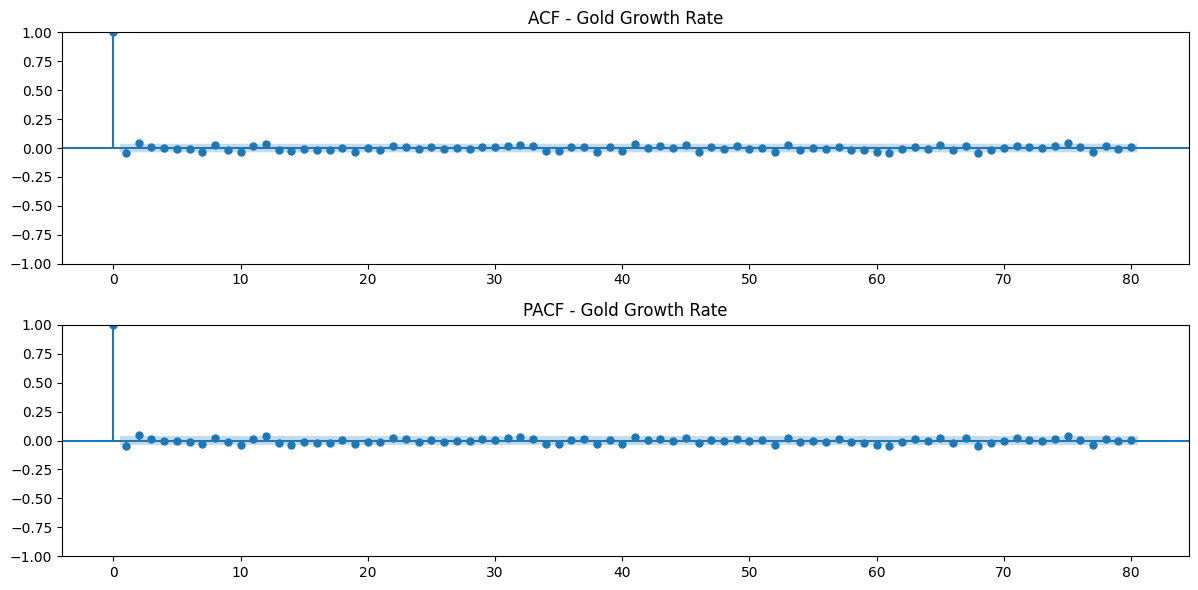

In [55]:
# Drop missing or infinite values from the series
growth_rate_clean = gold_dataset['Growth_Rate'].replace([np.inf, -np.inf], np.nan).dropna()

fig, axs = plt.subplots(2, 1, figsize=(12, 6))

# ACF plot (for MA terms)
plot_acf(growth_rate_clean, ax=axs[0], lags=80)
axs[0].set_title('ACF - Gold Growth Rate')

# PACF plot (for AR terms)
plot_pacf(growth_rate_clean, ax=axs[1], lags=80, method='ols')
axs[1].set_title('PACF - Gold Growth Rate')

plt.tight_layout()
plt.show()